# Lab 2: Set Covering with Genetic Algorithms


## Task

Given a number $N$ and some lists of integers $P = (L_0, L_1, L_2, ..., L_n)$,
determine is possible $S = (L_{s_0}, L_{s_1}, L_{s_2}, ..., L_{s_n})$
such that each number between $0$ and $N-1$ appears in at least one list

$$\forall n \in [0, N-1] \ \exists i : n \in L_{s_i}$$

and that the total numbers of elements in all $L_{s_i}$ is minimum.

## THE PROBLEM MUST BE SOLVED WITH GENETIC ALGORITHMS
## DEPENDENCIES

In [73]:
import copy
import random
from matplotlib import pyplot as plt
from collections import namedtuple


PENALTY_THRESHOLD = 1000000000
NUM_GENERATIONS = 1000

SEED = 42
Individual = namedtuple("Individual", ["genome", "fitness"])

## Input generator

In [74]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [75]:
def goal_test(state):
    return set(sum((e for e in state), start=())) == GOAL

In [76]:
def w(genome):
    if goal_test(genome) is False:
        return -PENALTY_THRESHOLD
    else:
        return -sum([len(i) for i in genome])


def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def cross_over(g1, g2, all_lists):
    cut = random.randint(0, min([len(g1), len(g2)]))
    new = set(g1[:cut] + g2[cut:])
    if len(new) < N:
        pick_one = random.choice(list(set(all_lists) - new))
        new = g1[:cut] + [pick_one] + g2[cut + 1:]
        return new
    else:
        return ([])


def mutation(g, all_lists):
    point = random.randint(0, len(g) - 1)
    pick_one = random.choice(list(set(all_lists) - set(g)))
    new = g[:point] + [pick_one] + g[point + 1:]
    return new

def find_bloat(g, countN):
    bloatN = list()
    for i in g:
        wsum=0
        for e in i:
            wsum += countN.get(e)
        bloatN.append(wsum/len(i))
    return bloatN.index(max(bloatN))


def mutation_shut_down(g):
    countN = dict()
    for i in g:
        for e in i:
            if countN.get(e) is None:
                countN[e] = 1
            else:
                countN[e] = countN.get(e) + 1
    point = find_bloat(g, countN)
    return g[:point] + g[point + 1:]


## The following cell contains _unused_ code, please ignore it.

In [77]:
# mutation 3 is never used! (just an alternative version)
def mutation3(g, all_lists):
    countN = dict()
    for i in g:
        for e in i:
            if countN.get(e) is None:
                countN[e] = 1
            else:
                countN[e] = countN.get(e) + 1
    point = find_bloat(g, countN)
    best = g
    for _ in range(1):    # The parameter inside the range function can be tuned
        pick_one = random.choice(list(set(all_lists) - set(g)))
        new = g[:point] + [pick_one] + g[point + 1:]
        best = new

    return best

## First individuals generator

In [78]:
def generate_population(N):
    problem_out = problem(N, SEED)
    all_lists = list(set(tuple(sorted(_)) for _ in problem_out))
    population = list()
    if N != 1000:
        POPULATION_SIZE = N * 20
    else:
        POPULATION_SIZE = N
    for _ in range(POPULATION_SIZE):
        genome = random.sample(all_lists, random.randint(1, N))
        population.append(Individual(genome, w(genome)))

    return population, all_lists


## Evolutionary Controller

In [79]:
def performance_eval(fitness_log, N):


    gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(max(fitness_log, key=lambda x: x[0])[0])]
    plt.figure(figsize=(15, 6))
    plt.title(f"N: {N}")

    if N == 100:
        plt.ylim(-3*N, -N)
    elif N == 500:
        plt.ylim(-5*N, -N)
    else:
        plt.ylim(-10*N, -N)

    plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
    #plt.plot([x for x, _ in enumerate(avg_line)], [y for _, y in enumerate(avg_line)])


In [80]:
def let_it_grow(N, INITIAL_POPULATION, all_lists, performance_flag=False):
    POPULATION = copy.deepcopy(INITIAL_POPULATION)
    best = Individual([], -PENALTY_THRESHOLD)
    fitness_log = [(0, i.fitness) for i in POPULATION]
    off_dict = dict()
    off_dict[5] = 5
    off_dict[10] = 9
    off_dict[20] = 15
    off_dict[50] = 30
    off_dict[100] = 90
    off_dict[500] = 200
    off_dict[1000] = 200
    offspring_size = off_dict[N]

    optim_flag = False

    generations_to_complete = 0
    old_best_fitness = -PENALTY_THRESHOLD
    for g in range(NUM_GENERATIONS):
        offspring = list()
        for i in range(offspring_size):
            randomness = 0.8
            outcome = random.random()
            if g < NUM_GENERATIONS / 2:
                randomness = 0.3
            if outcome < randomness/2:
                p = tournament(POPULATION)
                o = mutation(p.genome, all_lists)
            elif randomness/2 < outcome < randomness :
                p = tournament(POPULATION)
                o = mutation_shut_down(p.genome)
            else:
                p1 = tournament(POPULATION)
                p2 = tournament(POPULATION)
                o = cross_over(p1.genome, p2.genome, all_lists)
            f = w(o)
            fitness_log.append((g, f))
            offspring.append(Individual(o, f))
        POPULATION += offspring
        POPULATION = sorted(POPULATION, key=lambda i: i.fitness, reverse=True)[:N]
        if POPULATION[0].fitness > best.fitness:
            best = POPULATION[0]
        if g % 200 == 0:
            if POPULATION[0].fitness - old_best_fitness < 0.001 * N:
                generations_to_complete = g
                break
            else:
                old_best_fitness = POPULATION[0].fitness

    if optim_flag is not True:
        print(f"solution: {best.genome}")
        print(f"total cost: {-best.fitness}")
        print(f"Stopping after {generations_to_complete if generations_to_complete != 0 else NUM_GENERATIONS} generations.")

    if performance_flag is True and N not in [5, 10, 20, 50]:
        performance_eval(fitness_log, N)

## Script

Searching solution for N = 5
solution: [(2, 3), (0,), (4,), (1,)]
total cost: 5
Stopping after 200 generations.
------------------------------------------------------------
Searching solution for N = 10
solution: [(4, 5, 6), (0, 1), (2, 7, 8), (3, 9)]
total cost: 10
Stopping after 400 generations.
------------------------------------------------------------
Searching solution for N = 20
solution: [(4, 5, 8, 13, 15, 16, 17, 19), (3, 6, 7, 10, 14, 17), (6, 9, 11, 12, 17), (0, 1, 2, 3, 6, 13, 17, 18)]
total cost: 27
Stopping after 400 generations.
------------------------------------------------------------
Searching solution for N = 50
solution: [(0, 1, 6, 9, 11, 12, 15, 16, 17, 18, 22, 27, 32, 33, 34, 39, 43, 44, 46), (1, 4, 7, 11, 12, 13, 18, 23, 26, 28, 29, 31, 34, 35, 36, 37, 43, 44, 45, 46, 49), (1, 2, 16, 22, 23, 24, 30, 40, 47), (7, 9, 10, 14, 19, 20, 22, 33, 45), (1, 3, 4, 5, 7, 8, 12, 13, 15, 17, 21, 25, 29, 36, 38, 40, 41, 42, 48)]
total cost: 77
Stopping after 400 generations.

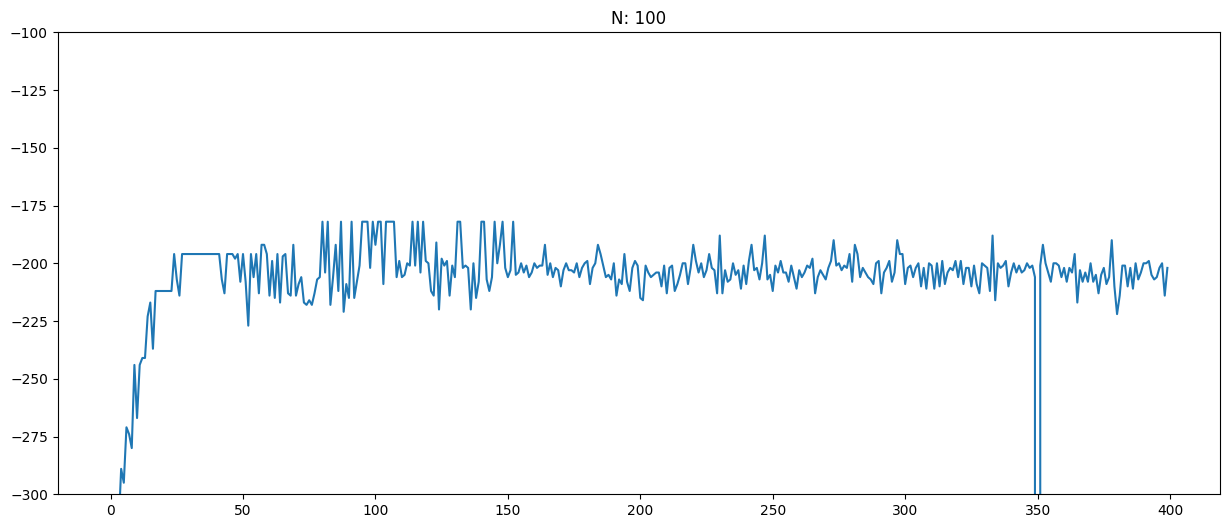

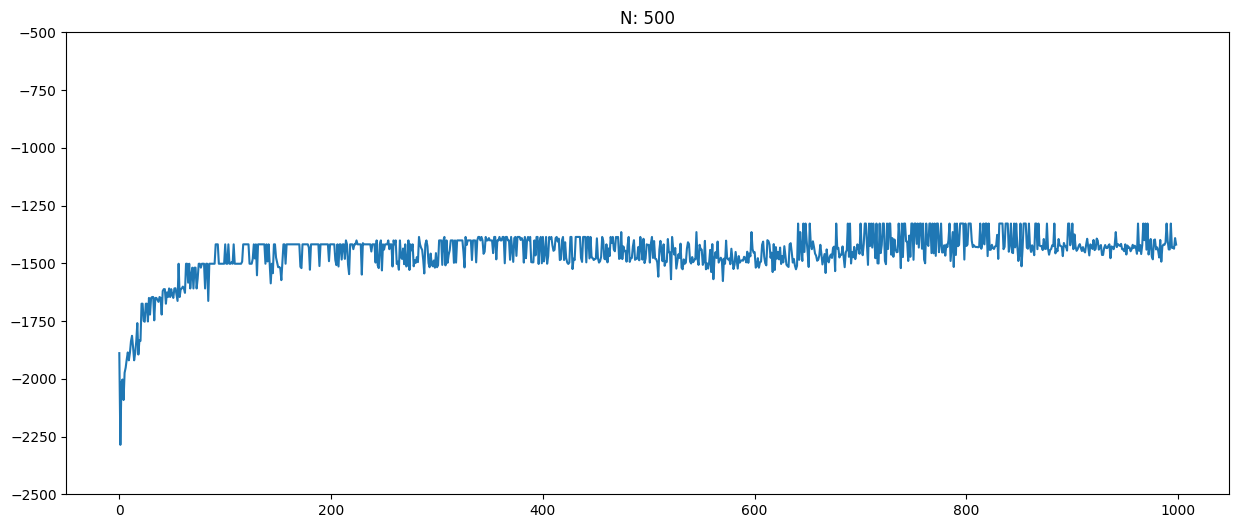

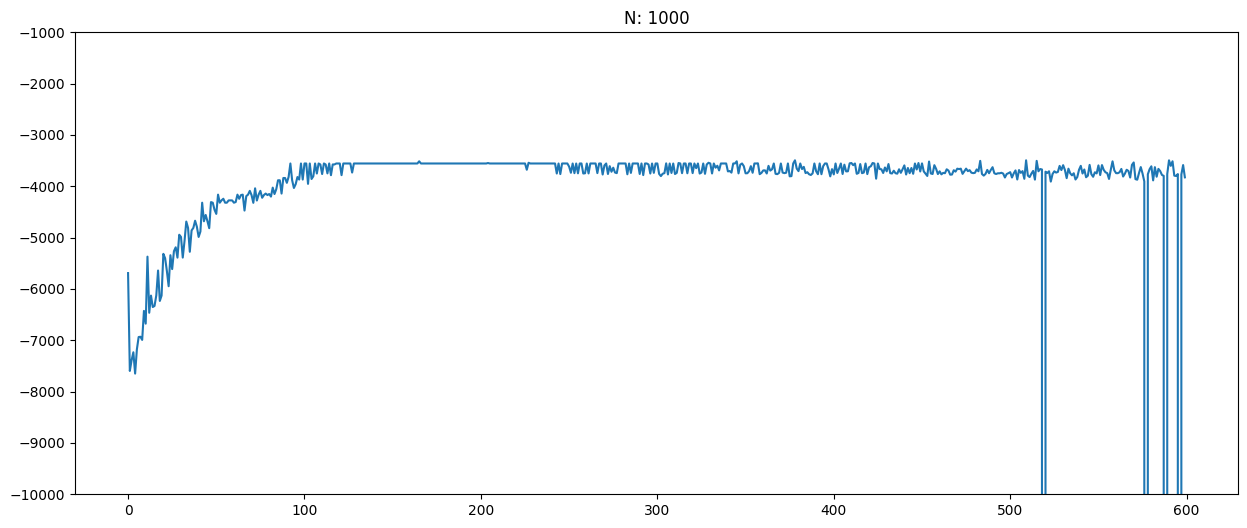

In [81]:
for N in [5, 10, 20, 50, 100, 500, 1000]:

    GOAL = set(range(N))
    INITIAL_POPULATION, all_lists = generate_population(N)

    print(f"Searching solution for N = {N}")
    let_it_grow(N, INITIAL_POPULATION, all_lists, performance_flag=True)
    print("------------------------------------------------------------")